In [42]:
import os
import inspect
import pandas as pd
from PIL import Image

import prefect
import datetime
from prefect.tasks.shell import ShellTask
from prefect import Flow,task, Parameter
from prefect.schedules import IntervalSchedule
from prefect.engine.signals import SKIP

In [43]:
@task
def filepath(Xfolder,SFolder,Folder,File):

    cwd = os.path.dirname(os.path.dirname(os.path.abspath(inspect.stack()[0][1])))
    print(cwd)
    read_file = os.path.join(cwd,Xfolder,SFolder,Folder,File)
    return read_file

In [44]:
@task
def git_command(url, target):
    """
    The git command we wish to execute
    """
    return "! git clone {url} {target}".format(target=target, url=url)




In [45]:
@task
def rm_cmd(fpath):
    """
    The git command we wish to execute
    """
    return "rm -r {fpath}".format(fpath=fpath)
    
    
    

In [46]:
# ShellTask is a task from the Task library which will execute a given command in a subprocess
# and fail if the command returns a non-zero exit code


git_clone = ShellTask(name="cloning", max_retries=2, retry_delay=datetime.timedelta(seconds=15))
remove_files = ShellTask(name="clearing_targer_folder",max_retries=2, retry_delay=datetime.timedelta(seconds=5))

In [47]:
with Flow ('ETL') as flow:
    
    #Input Parameters
    target_location=filepath("","","","data")
    git_url = Parameter("git_url",
                     default="https://github.com/ieee8023/covid-chestxray-dataset")
    
    
    ### Extraction
    
    #clearing folders
    clear_target_location_command=rm_cmd(target_location)
    clearing_target_location=remove_files(command=clear_target_location_command)
    
    #Cloning git repo
    git_command = git_command(git_url,target_location)
    raw_data = git_clone(command=git_command,upstream_tasks=[clearing_target_location])
    
    ### Transform
    
    
    
    ### Load
    
    


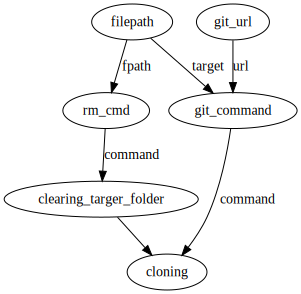

In [48]:
flow.visualize()

In [49]:
flow.run()

[2020-09-09 02:03:35] INFO - prefect.FlowRunner | Beginning Flow run for 'ETL'
[2020-09-09 02:03:35] INFO - prefect.TaskRunner | Task 'filepath': Starting task run...
/home/ubuntu/data_pipeline
[2020-09-09 02:03:35] INFO - prefect.TaskRunner | Task 'filepath': finished task run for task with final state: 'Success'
[2020-09-09 02:03:35] INFO - prefect.TaskRunner | Task 'git_url': Starting task run...
[2020-09-09 02:03:35] INFO - prefect.TaskRunner | Task 'git_url': finished task run for task with final state: 'Success'
[2020-09-09 02:03:35] INFO - prefect.TaskRunner | Task 'rm_cmd': Starting task run...
[2020-09-09 02:03:35] INFO - prefect.TaskRunner | Task 'rm_cmd': finished task run for task with final state: 'Success'
[2020-09-09 02:03:35] INFO - prefect.TaskRunner | Task 'git_command': Starting task run...
[2020-09-09 02:03:35] INFO - prefect.TaskRunner | Task 'git_command': finished task run for task with final state: 'Success'
[2020-09-09 02:03:35] INFO - prefect.TaskRunner | Task

<Success: "All reference tasks succeeded.">